In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import mglearn
from sklearn.model_selection import train_test_split

%matplotlib inline

In [28]:
dt_origin = np.linspace(0, 5, 11)
dt_digtiz = np.digitize(dt_origin, np.arange(3) * 2 + 2)
dt = pd.DataFrame({ "origin": a, "digitize": b })
dt

,origin,digitize
0,0.0,0
1,0.5,0
2,1.0,0
3,1.5,0
4,2.0,1
5,2.5,1
6,3.0,1
7,3.5,1
8,4.0,2
9,4.5,2


# 交互作用と多項式
1次元のデータに対する線形モデルでも表現を変える事で複雑な形状を学習できる。

* 1次元の連続値を区間で分け(ビニング)
* 区間に番号を振る(離散化)
* 1-of-K表現に変換

In [53]:
from sklearn.preprocessing import OneHotEncoder

# 1-of-k。OneHotとも呼ぶ
res = OneHotEncoder(categories="auto").fit_transform(dt["digitize"].values.reshape(-1, 1))
res.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

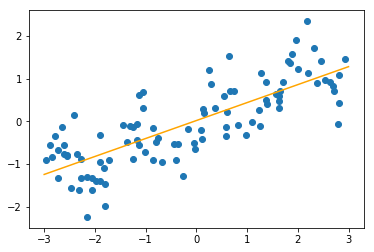

In [244]:
# 1次元のサンプルデータを作成
x, y = mglearn.datasets.make_wave()
plt.scatter(x, y)

from sklearn.linear_model import LinearRegression
es = LinearRegression().fit(x, y)

# 線形回帰は低次元では表現力が低い
x_pred = np.linspace(-3, 3, 20).reshape(-1, 1)
plt.plot(x_pred, es.predict(x_pred), c="orange")

## ビニング (離散化)
ビニング、離散化、1-of-kで入力データを区間ごとに対応する次元が1になるデータへ変換し学習させる。学習結果は各区間の切片になる。決定木の様なカクカクとした決定境界になる。なお、ビニングは1つずつの特徴量にしか適用できない制約がある。

[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]


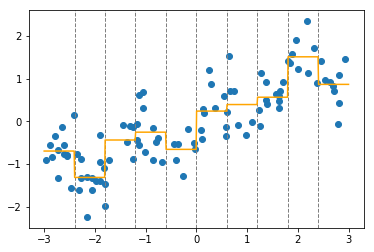

In [261]:
plt.scatter(x, y)

# ビン間隔
bins = np.linspace(-3, 3, 11)[1:-1]
for b in bins:
    plt.axvline(b, c="gray", lw=1, ls="--")
print(bins)

# ビニング+離散化
x_digitiz = np.digitize(x, bins)

# 1-of-k 変換
x_mod = OneHotEncoder(categories=[range(bins.size + 1)]).fit_transform(x_digitiz).toarray()

# 線形モデルで学習
es = LinearRegression().fit(x_mod, y)

# 境界線をプロット
x_pred = np.linspace(-3, 3, 600).reshape(-1, 1)
x_digitiz = np.digitize(x_pred, bins)
x_mod = OneHotEncoder(categories=[range(bins.size + 1)]).fit_transform(x_digitiz).toarray()

plt.plot(x_pred, es.predict(x_mod), c="orange")

## 区間ごとの傾きも学習させる
訓練データを区間ごとに次元を分けると、区間ごとに別の傾きを学習できる。

[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]


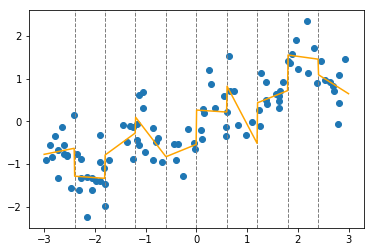

In [259]:
plt.scatter(x, y)

# ビン間隔
bins = np.linspace(-3, 3, 11)[1:-1]
for b in bins:
    plt.axvline(b, c="gray", lw=1, ls="--")
print(bins)

# ビニング+離散化
x_digitiz = np.digitize(x, bins)

# 1-of-k 変換
x_mod = OneHotEncoder(categories=[range(bins.size + 1)]).fit_transform(x_digitiz).toarray()

# 新規追加
# 区間ごとにx_modで切片を、x*x_modで傾きを学習
x_mod = np.hstack((x_mod, x * x_mod))

# 線形モデルで学習
es = LinearRegression().fit(x_mod, y)

# 境界線をプロット
x_pred = np.linspace(-3, 3, 600).reshape(-1, 1)
x_digitiz = np.digitize(x_pred, bins)
x_mod = OneHotEncoder(categories=[range(bins.size + 1)]).fit_transform(x_digitiz).toarray()
x_mod = np.hstack((x_mod, x_pred * x_mod))

plt.plot(x_pred, es.predict(x_mod), c="orange")

## 特徴量の多項式化
特徴量へ交互作用、非線形を加えることでも表現力を強化できる。これはPolynomialFeaturesを使うことで処理可能。

### パラメータ

* degree  
  何次変数までの組み合わせを求めるかを指定。デフォルトは2 (1～2次項までを作る)
* interaction_only  
  相互作用項のみ生成
* include_bias  
  切片(常に1)を生成

In [277]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
print(poly.fit_transform([[2, 3]]))
print(poly.get_feature_names())

[[2. 3. 4. 6. 9.]]
['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']


In [284]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
print(poly.fit_transform([[2, 3]]))
print(poly.get_feature_names())

[[2. 3. 6.]]
['x0', 'x1', 'x0 x1']


多項式化した上で線形モデルで学習させる。これは古典的な多項式回帰モデルになる。サンプルデータの小さい波形をしつつ右肩上がりをする分布にSVMの様な複雑なモデル並によく適合する。しかし、n個のデータはn-1次の多項式で完全一致できる(過学習)点に注意が必要。

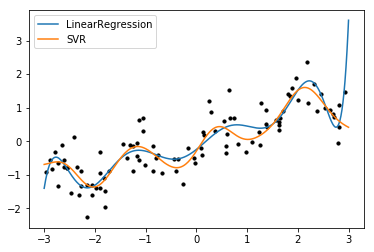

In [398]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# 線形モデルで学習
# 10次項までの組み合わせを作る
polyf = PolynomialFeatures(degree=10).fit(x)
x_mod = polyf.transform(x)
liner = LinearRegression().fit(x_mod, y)

# 境界線をプロット(線形モデル)
x_pred = np.linspace(-3, 3, 600).reshape(-1, 1)
x_pred_mod = x_pred
x_pred_mod = poly.transform(x_pred_mod)
plt.plot(x_pred, liner.predict(x_pred_mod), label=type(liner).__name__)

# SVMモデルで学習
# 多項式化せずに訓練する
scaler = MinMaxScaler().fit(x)
x_mod = scaler.transform(x)
svm = SVR(gamma=100).fit(x_mod, y)

# 境界線をプロット(SVMモデル)
x_pred = np.linspace(-3, 3, 600).reshape(-1, 1)
x_pred_mod = x_pred
x_pred_mod = scaler.transform(x_pred_mod)
plt.plot(x_pred, svm.predict(x_pred_mod), label=type(svm).__name__)

plt.scatter(x, y, c="k", s=10)
plt.legend()

# 単変量非線形変換
log, exp, sinなどを基底関数に使用するのも良い。分布の形状によっては精度が向上する。

Text(0.5, 1.0, '$log x$')

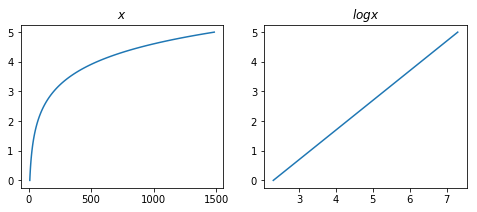

In [421]:
y = np.linspace(0, 5, 100)
x = 10 * np.exp(y)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.title("$x$")

# 線形モデルとの相性はこちらが良い
plt.subplot(1, 2, 2)
plt.plot(np.log(x), y)
plt.title("$log x$")

# 自動特徴量選択
実世界のデータで特徴量削減が大幅な性能向上に繋がることはあまり無い。しかし、入力に何を使えば良いか分からない場合や、推論の高速化、解釈しやすいモデル構築に役立つ。

## 単変量統計
個々の特徴量に対しp値で重要度を判断する。SelectKBest, SelectPercentile を使うことが多い。前者は数、後者は割合で特徴量の数を決定する。特徴量が多すぎてモデル作成が出来ない場合や、関係無い特徴量が多いと思われる場合に有効

In [16]:
cancer = datasets.load_breast_cancer()
rnd = np.random.RandomState(42)
noise = rnd.normal(size=(len(cancer.data),50))
X_w_noise = np.hstack((cancer.data, noise))

# 特徴量に50個のノイズ変数を追加したデータを生成
X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=0.5)

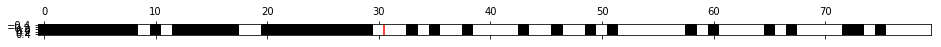

In [47]:
from sklearn.feature_selection import SelectPercentile

# 特徴量を半分切り捨て
select = SelectPercentile(percentile=50).fit(X_train, y_train)
sel_feature = select.get_support().reshape(1, -1)

# 黒が残った特徴量
plt.matshow(sel_feature, cmap="gray_r")
# 赤線より右側全てノイズ
plt.axvline(30.5, c="red")

## モデルベース特徴量選択
学習器を用いて特徴量の重量度を量る。モデルによっては複数の特徴量を考慮でき、単変量より強力。学習器に feature_importances_, coef_ が定義されていれば使える。L1正則化に似ているが、これの場合には正則化と推論で異なる学習器が使用可能。

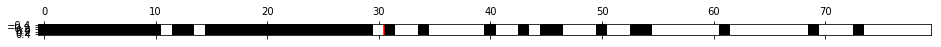

In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 特徴量を半分切り捨て (中央値未満が弾かれる)
rndfrst = RandomForestClassifier(100, random_state=42)
select = SelectFromModel(rndfrst, threshold="median").fit(X_train, y_train)
sel_feature = select.get_support().reshape(1, -1)

# 黒が残った特徴量
plt.matshow(sel_feature, cmap="gray_r")
# 赤線より右側全てノイズ
plt.axvline(30.5, c="red")

## 反復特徴量選択
モデルベース特徴量選択を更に進めたものとして全ての特徴量からの学習から始め1つずつ重要度の低い特徴量を減らす事を閾値まで繰り返す方法がある (**再帰的特徴量削減**)。高コスト

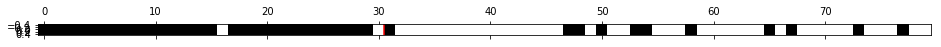

In [52]:
from sklearn.feature_selection import RFE

rndfrst = RandomForestClassifier(100, random_state=42)
select = RFE(rndfrst, n_features_to_select=40).fit(X_train, y_train)
sel_feature = select.get_support().reshape(1, -1)

# 黒が残った特徴量
plt.matshow(sel_feature, cmap="gray_r")
# 赤線より右側全てノイズ
plt.axvline(30.5, c="red")

# 専門家知識の利用
推論対象の専門家から知見を聞き出せれば、モデルの特徴量に加え精度向上ができる事がある。